# 機械学習とデータマイニングの基礎 第3回 レポート課題

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# コインの「表」が出る確率
THETA = 0.5

### 実験条件
* コインが1000枚ある。n回ずつ独立に投げて「表」か「裏」かを記録しておく。
* 1000枚のコインの裏表をベルヌーイ確率変数$C_1, C_2, \dots, C_{1000}$で表す。「表」を1, 「裏」を0とする。
* j番目のコインをn回投げた際、それぞれの回で出た目を$C_j(1), \dots, C_j(n)$と表す。
* 投げた回数にしめる「表」の割合を$\hat{C}_j = \frac{1}{n} \sum_{i = 1}^n C_j(i)$とする。
* $n = 10$とする。

##### 備考
* すべてのコインをn回ずつ投げるまでの一連の作業を「１試行」とする。

### 問題1
乱数を発生させて,先述の実験を 10 万試行分,実施すること

### 回答
1試行は以下のようなone_trial関数のように実装される。  
講義の流れを踏まえ、ベルヌーイ変数が1を取る確率(パラメータ$\theta$)は全てのコインで同じ値を使用する。  
これは、全てのコインが同一の分布に従うことを意味する。 ここでは、$\theta = 0.5$を採用した。 

指定された通り、このone_trial関数を10万試行分実施した。

In [3]:
def one_trial(n, coin_num=1000, random_state=0, verbose=True):
    '''
    coin_num枚のコインをn回投げる操作をした後
    それぞれのコインにおいて、n回中「表」が出た割合の配列を返す
    '''    
    np.random.seed(random_state)
    C_samples = np.random.binomial(n=1, p=THETA, size=(n, coin_num))  # それぞれのコインを同時に10回投げる
    C_hat = C_samples.mean(axis=0)  # 「表」が出た割合を求めて記録

    if verbose:
        print('shape of C: ', C_hat.shape)
    return C_hat

In [5]:
one_trial(n=10);

shape of C:  (1000,)


In [7]:
for _ in tqdm(range(pow(10, 5)), leave=False):
    one_trial(n=10, verbose=False);

  0%|          | 0/100000 [00:00<?, ?it/s]

### 問題2
試行ごとに,次の 3 種類のコインの表の割合($\hat{C}$)を記録しておくこと.
* $C_1$: 1番目のコイン
* $C_{rand}$:無作為に選んだコイン
* $C_{min}$:全コインのなかで,表の数がもっとも少なかったコイン

### 回答
以下のように実装した。

In [8]:
def do_whole_trial(T, n):
    '''1000枚のコインに対しn回コインを投げる試行(1試行)をT回行う
    '''
    C1_history = []
    C_rand_history = []
    C_min_history = []
    for i in tqdm(range(T), leave=False):
        # (1試行を行う) n回投げる操作を1000枚のコインに対し行う
        C_hat = one_trial(n=n, random_state=i, verbose=False)
        # 1番目のコインの「表」の割合を記録
        C1_history.append(C_hat[0])

        # 無作為に選んだコインの「表」の割合を記録
        np.random.seed(i)
        j_rand = np.random.randint(C_hat.shape[0])
        C_rand_history.append(C_hat[j_rand])

        # 「表」の数が最も出なかったコインの「表」の割合を記録
        j_min = np.argmin(C_hat)
        C_min_history.append(C_hat[j_min])
    C1_history_array = np.array(C1_history)
    C_rand_history_array = np.array(C_rand_history)
    C_min_history_array = np.array(C_min_history)
    return C1_history_array, C_rand_history_array, C_min_history_array

In [23]:
n10_C1_T, n10_C_rand_T, n10_C_min_T = do_whole_trial(T=pow(10, 5), n=10)

  0%|          | 0/100000 [00:00<?, ?it/s]

### 問題3
上記の結果として,$C_1$ と $C_{rand}$ と $C_{min}$それぞれ,10万点からなるデータセットが得られる.そ
の分布をヒストグラムで可視化すること

### 回答
以下のように、問題2で得られたデータセットをmatplotlib.pyplot.histを用いて可視化した。  
$C_1$の結果は左から1番目の図, $C_{rand}$の結果は左から2番目の図である。2つの図を比較すると、おおむね同一のヒストグラムとなっていることが読み取れる。  
実際これは、全く同じヒストグラムを表している。なぜなら、全てのコインは同一の分布を持つコインであるため、無作為に選出した$C_{rand}$のコインは$C_1$と全く同じ性質を持つからである。  

$C_{min}$のコインの結果は、左から3番目の図である。横軸に注目すると他の図と比べて目盛りの単位が小さくなっていることが読み取れる。  
これは、$C_{min}$が1試行のコインの中で出た「表」の割合から最も小さい値のみを集めて来たことに起因する。$C_{min}$がどのように$C_1, C_{rand}$と異なるかについては、問題4の回答で触れる。

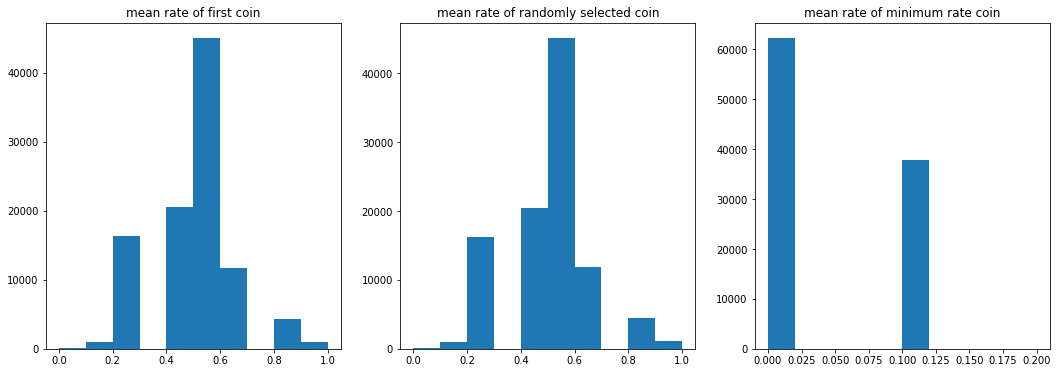

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

ax1 = axes[0]
ax1.set_title('mean rate of first coin')
ax1.hist(n10_C1_T)

ax_rand = axes[1]
ax_rand.set_title('mean rate of randomly selected coin')
ax_rand.hist(n10_C_rand_T)

ax_min = axes[2]
ax_min.set_title('mean rate of minimum rate coin')
ax_min.hist(n10_C_min_T)
plt.show()

### 問題4
この 3 種類のコインそれぞれに対して:
* A. P{|Cb − E[C]| > ε} を近似し,ε の関数としてそのグラフを描くこと.
* B. 同じプロットにおいて,Hoeffding の上界である $2\exp{−2\epsilon^2n}$のグラフも併せて表示すること.
* C. Hoeffding の不等式に従うコインと従わないコインはどれか.従わないコインはなぜ従わないか自分の言葉で説明すること.

### 回答
* A., B. 以下のグラフの通りである。
* C. Hoeffdingの不等式に従わないコインは以下の一番右の図から読み取れる通り$C_{min}$である。
* 「あとから見る」というチートをしている。「全体の中で最も小さい値である」という関係がある。

In [21]:
def get_hoeffding_bound(n, epsilon):
    '''
    n: サンプルサイズ
    epsilon: 誤差
    '''
    return 2 * np.exp(- 2 * epsilon**2 * n)

def see_error_vs_hoeffding_bound_figure(C1_T, C_rand_T, C_min_T, n):
    C_Ts = [C1_T, C_rand_T, C_min_T]
    titles = ['$C_1$ coin', '$C_{rand}$ coin', '$C_{min}$ coin']
    epsilons = np.linspace(0, 1, 10000)
    hoeffding_bounds = [get_hoeffding_bound(n=n, epsilon=eps) for eps in epsilons]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('probability of error between estimand and truth vs hoeffding\'s bound')

    for i, C_T in enumerate(C_Ts):
        p_eps_list = []

        for eps in epsilons:
            # NOTE: Cはベルヌーイ変数のためE[C] = THETA
            p_hat = np.mean(np.abs(C_T - THETA) > eps)  # Cの推定値が期待値からepsilonずれる確率をサンプルから推定
            p_eps_list.append(p_hat)
        axes[i].set_title(titles[i])
        axes[i].plot(epsilons, p_eps_list, label='error between estimand and truth')
        axes[i].plot(epsilons, hoeffding_bounds, label='hoeffding bound')
    plt.legend()
    plt.show()

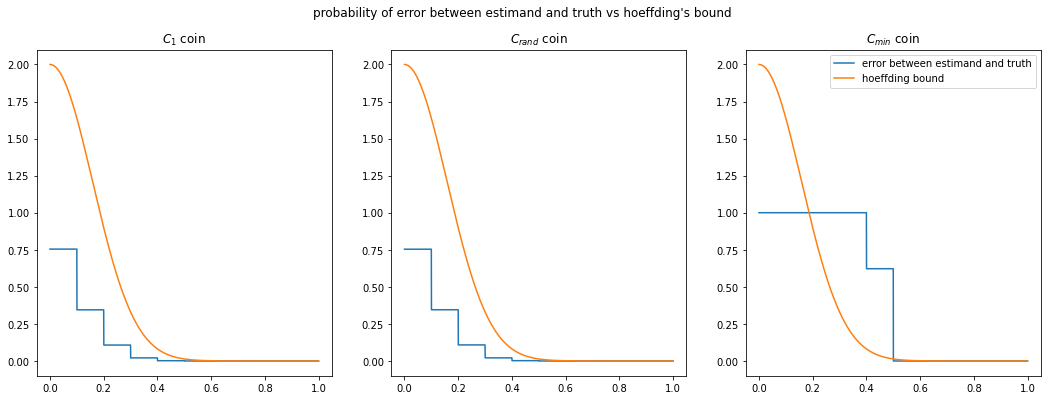

In [26]:
see_error_vs_hoeffding_bound_figure(n10_C1_T, n10_C_rand_T, n10_C_min_T, n=10)

### 課題5
標本数n(コインを投げる回数) を大幅に増やしてみること (n = 500 など).$C_{min}$ の分布が n = 10
のときと比べて,どのように変わるか.それはなぜか.

### 回答
* n=500の方が$C_{min}$の分布が正の方向に大きくシフトした。  
$n$が増えると推定値と真の値$\theta$との標準誤差は小さくなる。そのため、全体的に$\hat{C}_j$は$\theta = 0.5$に近づくため、その中で小さい値も$0.5$に近づくから。

In [20]:
_, _, n500_C_min_T = do_whole_trial(T=pow(10, 5), n=500)

  0%|          | 0/100000 [00:00<?, ?it/s]

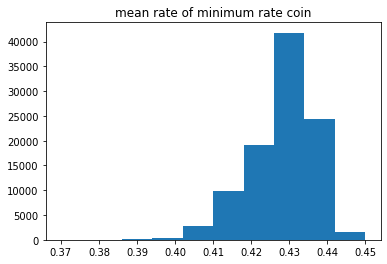

In [25]:
fig = plt.figure()
ax_min = fig.add_subplot()
ax_min.set_title('mean rate of minimum rate coin')
ax_min.hist(n500_C_min_T)
plt.show()

In [ ]:
m
